In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:28: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## 00 - Required data

In [2]:
city = 'Aguascalientes'

# Area of interest (city)
metro_schema = 'metropolis'
metro_table = 'metro_gdf_2015'

# Edges folder for distance analysis,
# also used to generate the network G with which the nearest OSMID is assigned to each poi
edges_folder = 'edges_speed'

# Pois data
pois_schema = ''
pois_table = ''
codes_test = [611111, 611112] #denue_preescolar
s = 'Preescolar'.lower()

# Network used to calculate distance from each node to nearest poi
prox_measure = 'time_min' #'length' or 'time_min'

### 00 - Required data - Area of interest

<Axes: >

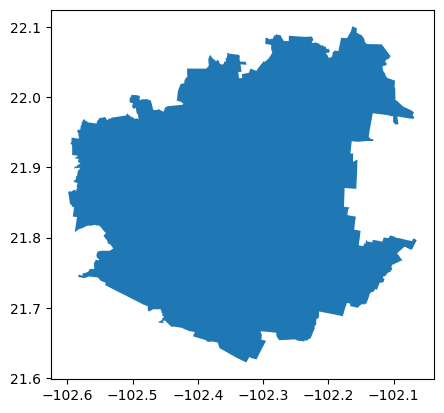

In [3]:
# Downloads hexagons within 'city'
query = f"SELECT * FROM {metro_schema}.{metro_table} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

mun_gdf = mun_gdf.set_crs("EPSG:4326")
aoi = mun_gdf.dissolve()

#Show
aoi.plot()

### 00 - Required data - pois

In [4]:
poly_wkt = aoi.dissolve().geometry.to_wkt()[0]

pois_schema = 'denue'
pois_table = 'denue_2020'

pois = gpd.GeoDataFrame()
for cod in codes_test:
    query = f"SELECT * FROM {pois_schema}.{pois_table} WHERE (ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')) AND (\"codigo_act\" LIKE \'{cod}\')"
    pois = pd.concat([pois,aup.gdf_from_query(query, geometry_col='geometry')])

pois = pois.rename(columns={'codigo_act':'code'})
pois['code'] = pois['code'].astype('int64')
pois = pois[['code','geometry']]

# Show
print(pois.shape)
pois.head(2)

(306, 2)


,code,geometry
0,611111,POINT (-102.27464 21.90191)
1,611111,POINT (-102.26601 21.85971)


### 00 - Required data - Networks

In [5]:
# Network used to calculate nearest note to each poi
G, nodes, edges = aup.graph_from_hippo(aoi, 'osmnx',edges_folder=edges_folder)

## 01 - Function development

In [9]:
#if prox_measure == 'length':
#    edges_speed = edges.copy()
#else:
#    _, nodes, edges_speed = aup.graph_from_hippo(aoi, 'osmnx', edges_folder=edges_folder)

In [14]:
# Defines projection for downloaded data
pois = pois.set_crs("EPSG:4326")
nodes = nodes.set_crs("EPSG:4326")
edges = edges.set_crs("EPSG:4326")

### Calculate nearest node for each DENUE point
nearest = aup.find_nearest(G, nodes, pois, return_distance= True)
nearest = nearest.set_crs("EPSG:4326")

# Show
print(nearest.shape)
nearest.head(2)

(306, 4)


,code,geometry,osmid,distance_node
0,611111,POINT (-102.27464 21.90191),961580633,16.377978
1,611111,POINT (-102.26601 21.85971),2253747737,71.553289


In [30]:
# FORMAT NETWORK
# Fill NANs with mean times
edges_speed[prox_measure].fillna(edges_speed[prox_measure].mean(),inplace=True)

# ELEMENTS NEEDED OUTSIDE THE LOOP
# df_temp: Each column will store a batch of procesed nodes.
df_temp = nodes.copy()

#nodes_distance: Minimum time/distance found in all batches will be added from df_min (within if/elif/else) to nodes_distance (output)
# (which keeps x,y and geometry data)
nodes_distance = nodes.copy()

# nodes_analysis is a nodes (index reseted) used in aup.calculate_distance_nearest_poi
nodes_analysis = nodes.reset_index().copy()

# PROCESSING
# Added first if in case there are no amenities of the type in the city. 
# Prevents it from Crashing if len = 0
if len(nearest) == 0:
    nodes_time['time'] = 0
    print(f"0 {s} found in {city}.")

elif len(nearest) % 250:
    batch_size = len(nearest)/200
    for k in range(int(batch_size)+1):
        #---------------------------------------------------------------------------------------------------------------------------------------------
        print(f"Starting range k = {k+1} of {int(batch_size)+1} for source {s}.")
        #---------------------------------------------------------------------------------------------------------------------------------------------
        source_process = nearest.iloc[int(200*k):int(200*(1+k))].copy()
        nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges_speed, s, 'osmid', wght=prox_measure)

        #A middle gdf is created whose columns will be the name of the amenity and the batch number it belongs to
        df_int = pd.DataFrame()
        df_int['dist_'+str(k)+s] = nodes_distance_prep['dist_'+s]
        
        #The middle gdf is merged into the previously created temporary gdf to store the data by node, each batch in a column.
        df_temp = df_temp.merge(df_int, left_index=True, right_index=True)

    # Once finished, drop the non-distance values from the temporary gdf
    df_temp.drop(['x', 'y', 'street_count','geometry'], inplace = True, axis=1)

    #We apply the min function to find the minimum value. This value is sent to a new df_min
    df_min = pd.DataFrame()
    df_min['dist_'+s] = df_temp.min(axis=1)

    #We merge df_min which contains the shortest distance to the POI with nodes_distance which will store all final data
    nodes_distance = nodes_distance.merge(df_min, left_index=True, right_index=True)

    if prox_measure == 'length':
        # If used lenght, calculate time assuming walking speed = 4km/hr
        nodes_time = nodes_distance.copy()
        nodes_time['time'] = (nodes_time['dist_'+s]*60)/4000
    else:
        nodes_time = nodes_distance.copy()
        nodes_time['time'] = nodes_time['dist_'+s]

else:
    batch_size = len(nearest)/250
    for k in range(int(batch_size)+1):
        #---------------------------------------------------------------------------------------------------------------------------------------------
        print(f"Starting range k = {k+1} of {int(batch_size)+1} for source {s}.")
        #---------------------------------------------------------------------------------------------------------------------------------------------
        source_process = nearest.iloc[int(250*k):int(250*(1+k))].copy()
        nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges_speed, s, 'osmid', wght=prox_measure)

        #A middle gdf is created whose columns will be the name of the amenity and the batch number it belongs to
        df_int = pd.DataFrame()
        df_int['dist_'+str(k)+s] = nodes_distance_prep['dist_'+s]

        #The middle gdf is merged into the previously created temporary gdf to store the data by node, each batch in a column.
        df_temp = df_temp.merge(df_int, left_index=True, right_index=True)

    # Once finished, drop the non-distance values from the temporary gdf
    df_temp.drop(['x', 'y', 'street_count','geometry'], inplace = True, axis=1)

    #We apply the min function to find the minimum value. This value is sent to a new df_min
    df_min = pd.DataFrame()
    df_min['dist_'+s] = df_temp.min(axis=1)

    #We merge df_min which contains the shortest distance to the POI with nodes_distance which will store all final data
    nodes_distance = nodes_distance.merge(df_min, left_index=True, right_index=True)

    if prox_measure == 'length':
        # If used lenght, calculate time assuming walking speed = 4km/hr
        nodes_time = nodes_distance.copy()
        nodes_time['time'] = (nodes_time['dist_'+s]*60)/4000
    else:
        nodes_time = nodes_distance.copy()
        nodes_time['time'] = nodes_time['dist_'+s]

#Format nodes_time
nodes_time['source'] = s
nodes_time.reset_index(inplace=True)
nodes_time = nodes_time.set_crs("EPSG:4326")
nodes_time = nodes_time[['osmid','time','source','x','y','geometry']]

# Show
print(nodes_time.shape)
nodes_time.head(3)

Starting range k = 1 of 2 for source preescolar.
Starting range k = 2 of 2 for source preescolar.
(51371, 6)


,osmid,time,source,x,y,geometry
0,272921360,10.557825,preescolar,-102.295073,21.872876,POINT (-102.29507 21.87288)
1,272921393,8.820540,preescolar,-102.295097,21.871411,POINT (-102.29510 21.87141)
2,280093727,15.769410,preescolar,-102.276792,21.718777,POINT (-102.27679 21.71878)


## 02 - Function

In [6]:
def sources_time(G, nodes, edges, pois, s, prox_measure):
    ############################################################################################################################################################################
    # NEAREST
    # Finds nearest node OSMID to each point of interest
    ############################################################################################################################################################################
    
    # Defines projection for downloaded data
    pois = pois.set_crs("EPSG:4326")
    nodes = nodes.set_crs("EPSG:4326")
    edges = edges.set_crs("EPSG:4326")
    
    ### Calculate nearest node for each DENUE point
    nearest = aup.find_nearest(G, nodes, pois, return_distance= True)
    nearest = nearest.set_crs("EPSG:4326")
    
    ############################################################################################################################################################################
    # NODES DISTANCE
    # Calculates distance from each node to its nearest point of interest
    ############################################################################################################################################################################
    
    # --------------------------------------------------------------------------------- FORMAT NETWORK
    # Fill NANs with mean times
    edges[prox_measure].fillna(edges[prox_measure].mean(),inplace=True)
    
    # --------------------------------------------------------------------------------- ELEMENTS NEEDED OUTSIDE THE LOOP
    # df_temp: Each column will store a batch of procesed nodes.
    df_temp = nodes.copy()
    
    #nodes_distance: Minimum time/distance found in all batches will be added from df_min (within if/elif/else) to nodes_distance (output)
    # (which keeps x,y and geometry data)
    nodes_distance = nodes.copy()
    
    # nodes_analysis is a nodes (index reseted) used in aup.calculate_distance_nearest_poi
    nodes_analysis = nodes.reset_index().copy()
    
    # --------------------------------------------------------------------------------- PROCESSING
    # Added first if in case there are no amenities of the type in the city. 
    # Prevents it from Crashing if len = 0
    if len(nearest) == 0:
        nodes_time['time'] = 0
        print(f"0 {s} found in {city}.")
    
    elif len(nearest) % 250:
        batch_size = len(nearest)/200
        for k in range(int(batch_size)+1):
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"Starting range k = {k+1} of {int(batch_size)+1} for source {s}.")
            #---------------------------------------------------------------------------------------------------------------------------------------------
            source_process = nearest.iloc[int(200*k):int(200*(1+k))].copy()
            nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges, s, 'osmid', wght=prox_measure)
    
            #A middle gdf is created whose columns will be the name of the amenity and the batch number it belongs to
            df_int = pd.DataFrame()
            df_int['dist_'+str(k)+s] = nodes_distance_prep['dist_'+s]
            
            #The middle gdf is merged into the previously created temporary gdf to store the data by node, each batch in a column.
            df_temp = df_temp.merge(df_int, left_index=True, right_index=True)
    
        # Once finished, drop the non-distance values from the temporary gdf
        df_temp.drop(['x', 'y', 'street_count','geometry'], inplace = True, axis=1)
    
        #We apply the min function to find the minimum value. This value is sent to a new df_min
        df_min = pd.DataFrame()
        df_min['dist_'+s] = df_temp.min(axis=1)
    
        #We merge df_min which contains the shortest distance to the POI with nodes_distance which will store all final data
        nodes_distance = nodes_distance.merge(df_min, left_index=True, right_index=True)
    
        if prox_measure == 'length':
            # If used lenght, calculate time assuming walking speed = 4km/hr
            nodes_time = nodes_distance.copy()
            nodes_time['time'] = (nodes_time['dist_'+s]*60)/4000
        else:
            nodes_time = nodes_distance.copy()
            nodes_time['time'] = nodes_time['dist_'+s]
    
    else:
        batch_size = len(nearest)/250
        for k in range(int(batch_size)+1):
            #---------------------------------------------------------------------------------------------------------------------------------------------
            print(f"Starting range k = {k+1} of {int(batch_size)+1} for source {s}.")
            #---------------------------------------------------------------------------------------------------------------------------------------------
            source_process = nearest.iloc[int(250*k):int(250*(1+k))].copy()
            nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges, s, 'osmid', wght=prox_measure)
    
            #A middle gdf is created whose columns will be the name of the amenity and the batch number it belongs to
            df_int = pd.DataFrame()
            df_int['dist_'+str(k)+s] = nodes_distance_prep['dist_'+s]
    
            #The middle gdf is merged into the previously created temporary gdf to store the data by node, each batch in a column.
            df_temp = df_temp.merge(df_int, left_index=True, right_index=True)
    
        # Once finished, drop the non-distance values from the temporary gdf
        df_temp.drop(['x', 'y', 'street_count','geometry'], inplace = True, axis=1)
    
        #We apply the min function to find the minimum value. This value is sent to a new df_min
        df_min = pd.DataFrame()
        df_min['dist_'+s] = df_temp.min(axis=1)
    
        #We merge df_min which contains the shortest distance to the POI with nodes_distance which will store all final data
        nodes_distance = nodes_distance.merge(df_min, left_index=True, right_index=True)
    
        if prox_measure == 'length':
            # If used lenght, calculate time assuming walking speed = 4km/hr
            nodes_time = nodes_distance.copy()
            nodes_time['time'] = (nodes_time['dist_'+s]*60)/4000
        else:
            nodes_time = nodes_distance.copy()
            nodes_time['time'] = nodes_time['dist_'+s]

    # --------------------------------------------------------------------------------- FINAL FORMAT
    #Format nodes_time
    nodes_time['source'] = s
    nodes_time.reset_index(inplace=True)
    nodes_time = nodes_time.set_crs("EPSG:4326")
    nodes_time = nodes_time[['osmid','time','source','x','y','geometry']]

    return nodes_time

In [7]:
nodes_time = sources_time(G, nodes, edges, pois, s, prox_measure)

# Show
print(nodes_time.shape)
nodes_time.head(3)

Starting range k = 1 of 2 for source preescolar.
Starting range k = 2 of 2 for source preescolar.
(51371, 6)


,osmid,time,source,x,y,geometry
0,272921360,10.770629,preescolar,-102.295073,21.872876,POINT (-102.29507 21.87288)
1,272921393,9.033784,preescolar,-102.295097,21.871411,POINT (-102.29510 21.87141)
2,280093727,16.752189,preescolar,-102.276792,21.718777,POINT (-102.27679 21.71878)


In [8]:
nodes_time.to_file('../../data/external/temporal_fromjupyter/proximity_v2/nodestime_time_min.gpkg', driver='GPKG')

## Time comparison [Success]

In [10]:
# Load nodes_time
nodes_time = gpd.read_file('../../data/external/temporal_fromjupyter/proximity_v2/nodestime_time_min.gpkg')

# Show
print(nodes_time.shape)
nodes_time.head(3)

(51371, 6)


,osmid,time,source,x,y,geometry
0,272921360,10.770629,preescolar,-102.295073,21.872876,POINT (-102.29507 21.87288)
1,272921393,9.033784,preescolar,-102.295097,21.871411,POINT (-102.29510 21.87141)
2,280093727,16.752189,preescolar,-102.276792,21.718777,POINT (-102.27679 21.71878)


In [15]:
nodes_schema = 'prox_analysis'
nodes_table = 'nodes_proximity_2020'

a = 'denue_preescolar'

nodes_time_org = gpd.GeoDataFrame()
query = f"SELECT * FROM {nodes_schema}.{nodes_table} WHERE \"metropolis\" LIKE \'{city}\' AND (\"amenity\" LIKE \'{a}\')"
nodes_time_org = aup.gdf_from_query(query, geometry_col='geometry')

# Show
print(nodes_time_org.shape)
nodes_time_org.head(2)

(51371, 7)


,osmid,x,y,geometry,time,amenity,metropolis
0,272921360,-102.295073,21.872876,POINT (-102.29507 21.87288),10.770629,denue_preescolar,Aguascalientes
1,808114976,-102.308667,21.896123,POINT (-102.30867 21.89612),5.508627,denue_preescolar,Aguascalientes


In [16]:
nodes_time.time.mean()

33.837910405263145

In [18]:
nodes_time_org.time.mean()

33.837910405263145